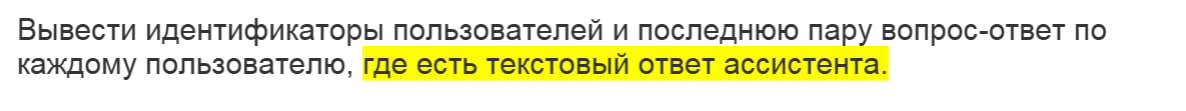

In [8]:
from IPython.display import Image
Image('2222.jpg')

Возможно, я не совсем корректно поняла логику хранения сообщений в таблице, т.к. пяти строк не хватает для выявления закономерностей. При решении задачи подразумеваю:
1. Для каждого пользователя каждой паре сообщений request-response присваивается уникальный MESSAGE_ID (как бы "поддиалог");
2. Очередность сообщений в каждом диалоге определяется временем записи сообщения в БД - поле CREATED.

Для удобства отобразим таблицу с помощью запроса:

In [ ]:
select user_id,
	   message_id,
	   message_type,
	   query,
	   created,
	   date(created) as mes_date, 
	   cast(strftime('%H', created) || strftime('%M', created) || strftime('%S', created) as integer) as mes_time
from messages
order by user_id asc, mes_date asc, mes_time asc;

Для гарантии корректной сортировки по времени (т.к. в строках есть лишние символы), сортировка идёт отдельно по дате и времени сообщения. (Время ковырять не совсем удобно, т.к. в SQLite, вроде, нет удобной функции для этого).

Результат запроса:

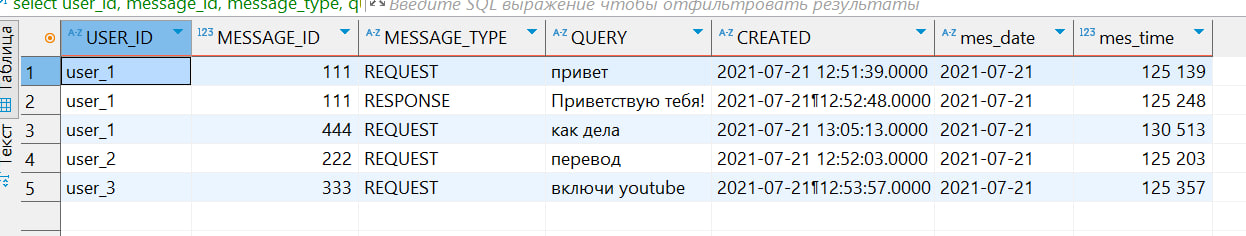

In [2]:
from IPython.display import Image
Image('2.jpg')

На примере user_1 видно, что он написал ассистенту, через минуту ему пришёл ответ, затем он где-то гулял 12 минут и следующее обращение к ассистенту стало началом нового "поддиалога" с новым MESSAGE_ID.
Видно, что пока user_1 гулял, кто-то другой писал ассистенту, но изначально мы разбиваем на группы по user_id, поэтому сортировка по времени даёт верный результат в рамках каждого польз-ля.

Запрос, основанный на вышесказанном:

In [ ]:
select 
    user_id,
    message_id,
    max(case when message_type = 'REQUEST' then QUERY end) as request,
    max(case when message_type = 'RESPONSE' then QUERY end) as response,
    max(date(created) || cast(strftime('%H', created) || strftime('%M', created) || strftime('%S', created) as integer)) as latest
  from MESSAGES
  group by user_id, message_id
  having count(distinct message_type) = 2;

Добавлю строки для проверки:

In [ ]:
INSERT INTO MESSAGES VALUES
(2, 555, 'user_2', 'REQUEST', 'hi', '2021-07-21 14:52:03.0000'),
(2, 555, 'user_2', 'RESPONSE', 'hello', '2021-07-21 15:52:03.0000'),
(2, 666, 'user_2', 'REQUEST', 'hiiii', '2021-07-21 16:52:03.0000'),
(2, 666, 'user_2', 'RESPONSE', 'hellooooo', '2021-07-21 17:52:03.0000');

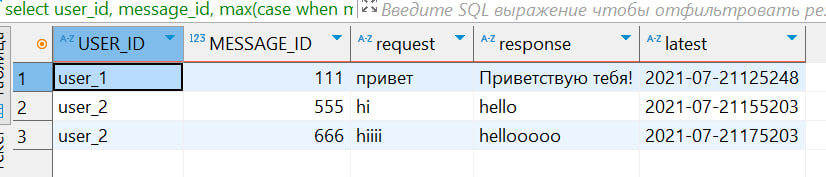

In [6]:
from IPython.display import Image
Image('22.jpg')

*осознание ошибки*

In [ ]:
with pairs as (
select 
    user_id,
    message_id,
    max(case when message_type = 'REQUEST' then QUERY end) as request,
    max(case when message_type = 'RESPONSE' then QUERY end) as response,
    ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY max(date(created) || cast(strftime('%H', created) || strftime('%M', created) || strftime('%S', created) as integer)) DESC) as rn
  from MESSAGES
  group by user_id, message_id
  having count(distinct message_type) = 2
)
select 
  user_id,
  request,
  response
from pairs
where rn = 1;

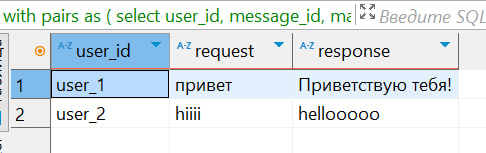

In [7]:
from IPython.display import Image
Image('222.jpg')